In [1]:
import re
import operator
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from wordcloud import WordCloud
from visualization_methods import VisualizationMethods as vm
from aggregation_methods import AggregationMethods as am
import data_methods as dm

df = dm.get_valid_dataframe()
df = df[df['repo_last_modified'] >= '2021-01-01T00:00:00:000']

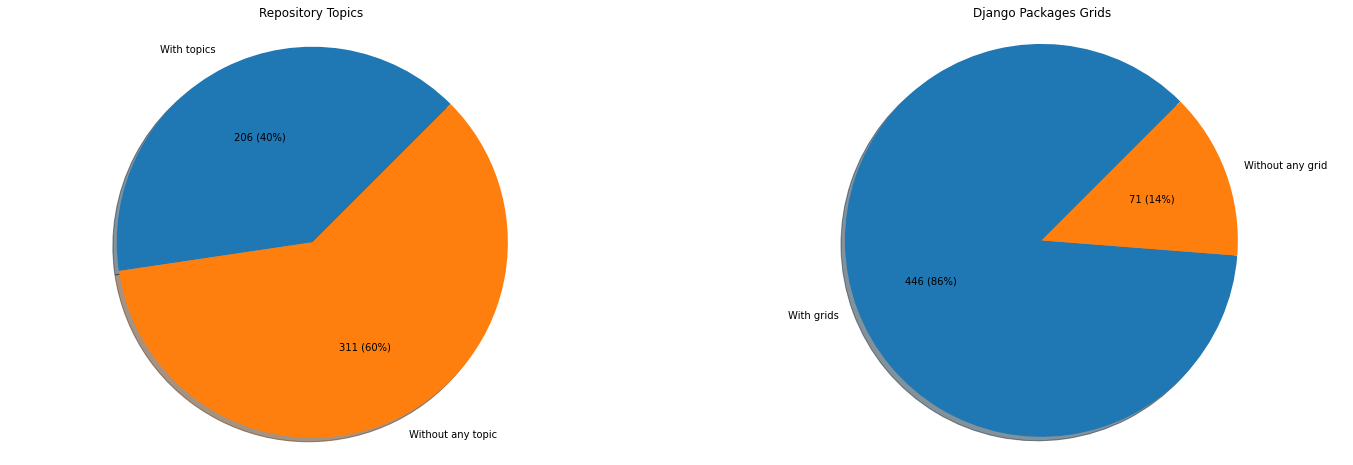

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
fig.set_facecolor('white')

sizes = [len(df[~df['repo_topics'].isnull()]), len(df[df['repo_topics'].isnull()])]
vm.set_pie_by_ax(ax1, sizes, ('With topics', 'Without any topic'), 'Repository Topics')

sizes = [len(df[~df['dp_grids'].isnull()]), len(df[df['dp_grids'].isnull()])]
vm.set_pie_by_ax(ax2, sizes, ('With grids', 'Without any grid'), 'Django Packages Grids')

plt.show()

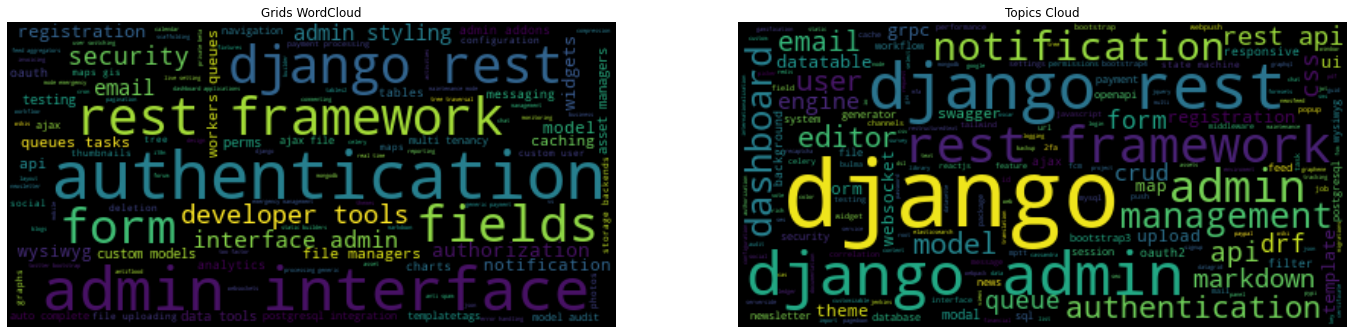

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
fig.set_facecolor('white')

grid_concate, grids_freq, grids_freq_by_stars = (
    am.get_concate_and_freqs(df, 'dp_grids', 'repo_stars', ['this-site'])
)

ax1.set_title('Grids WordCloud')
ax1.imshow(WordCloud().generate(grid_concate), interpolation='bilinear')
ax1.axis("off")

unwanted_topics = [ 'django', 'python', 'django-application', 'django-framework' ]
unwanted_regex = [ 
    re.compile(r'^(django)((\d+)|(\-\d+)|\Z)', re.IGNORECASE), 
    re.compile(r'^(python)((\d+)|(\-.*)|\Z)', re.IGNORECASE), 
    re.compile(r'^(hacktoberfest)((\-\d+)|(\d+)|\Z)', re.IGNORECASE)
]

topics_concate, topics_freq, topics_freq_by_stars = (
    am.get_concate_and_freqs(df, 'repo_topics', 'repo_stars', unwanted_topics, unwanted_regex)
)

ax2.set_title('Topics Cloud')
ax2.imshow(WordCloud().generate(topics_concate), interpolation='bilinear')
ax2.axis("off")

plt.show()

/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')
/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')


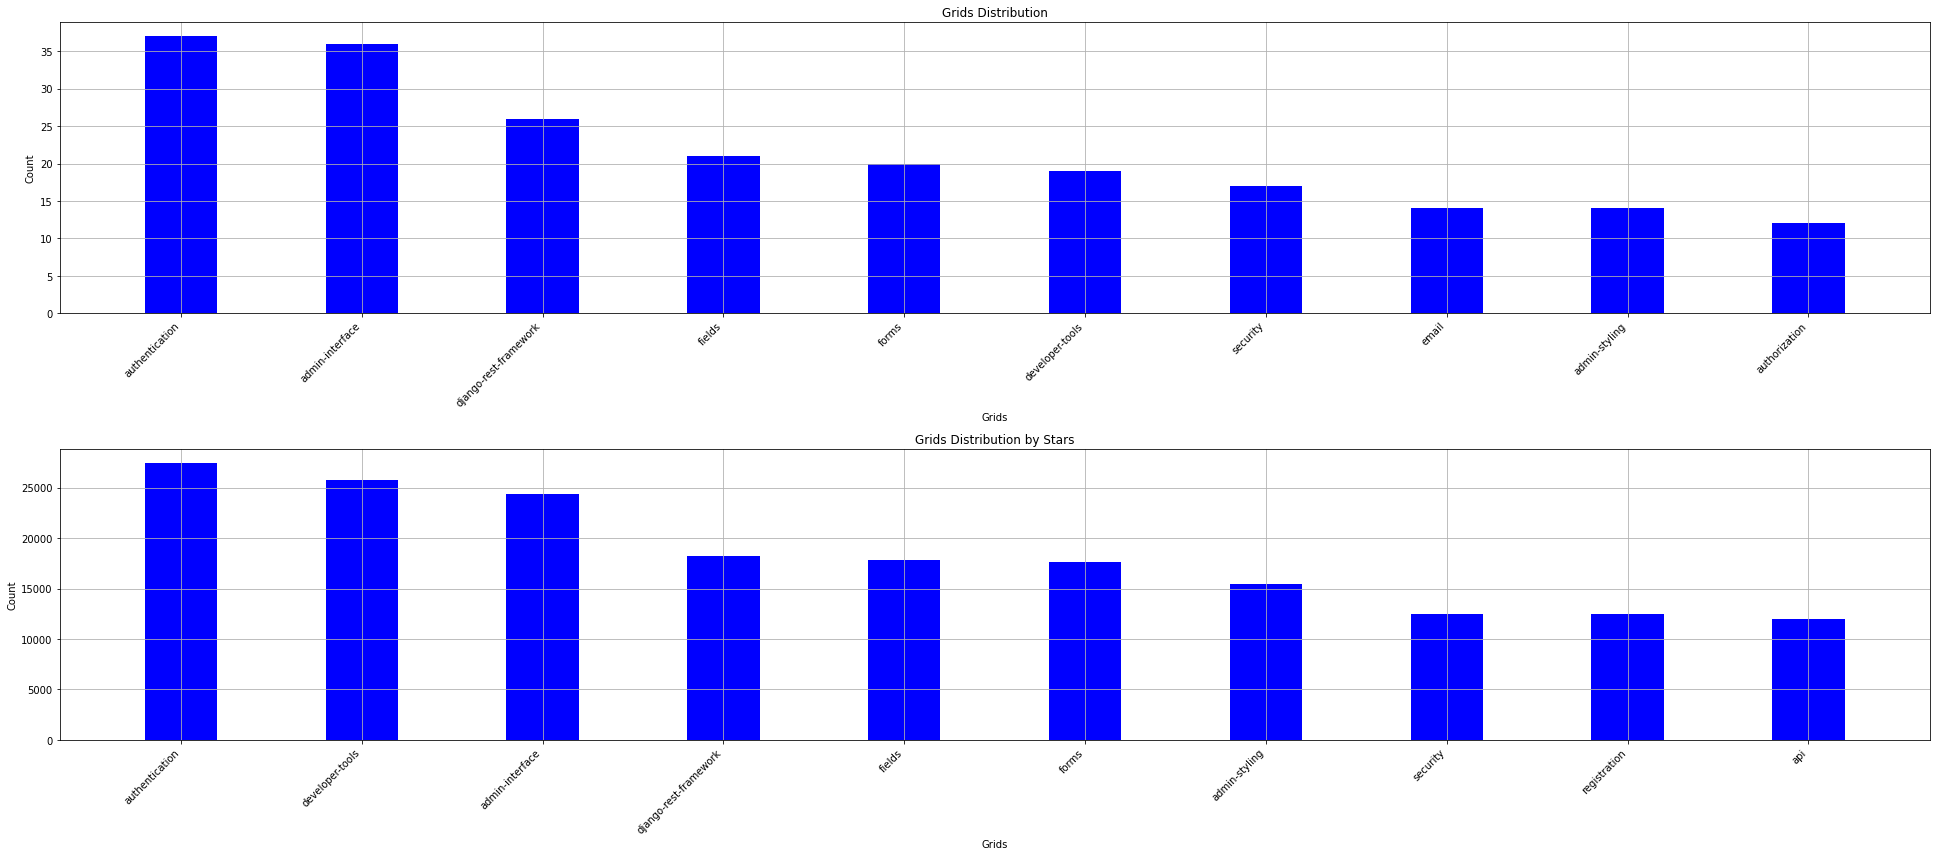

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(27, 12))

top = 10
top_grid_freq = {k[0]: k[1] for k in sorted(grids_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}
top_grid_freq_by_star = {k[0]: k[1] for k in sorted(grids_freq_by_stars.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict_and_ax(ax1, top_grid_freq, 'Grids', 'Count', 'Grids Distribution', 'blue')
vm.show_bar_chart_by_dict_and_ax(ax2, top_grid_freq_by_star, 'Grids', 'Count', 'Grids Distribution by Stars', 'blue')

plt.tight_layout()
plt.show()

/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')
/Users/rafaatsouza/Projects/django-packages-miner/visualization/visualization_methods.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys, rotation=45, ha='right')


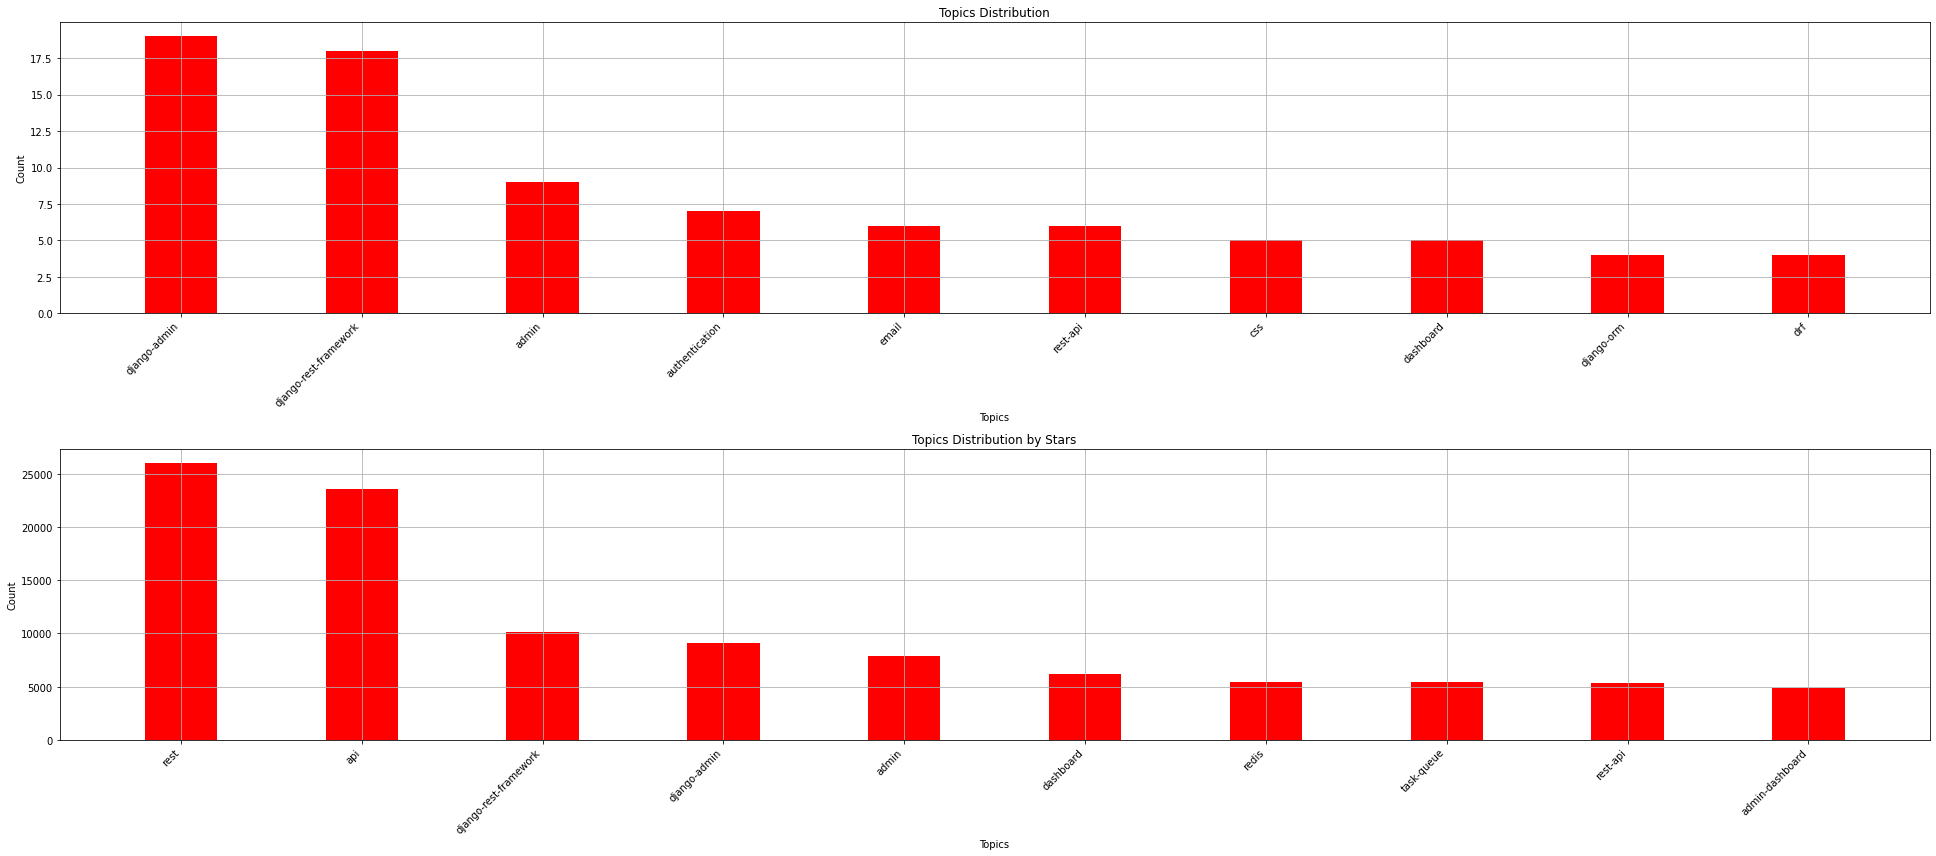

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(27, 12))

top = 10
top_repo_freq = {k[0]: k[1] for k in sorted(topics_freq.items(), key=operator.itemgetter(1), reverse=True)[:top]}
top_repo_freq_by_star = {k[0]: k[1] for k in sorted(topics_freq_by_stars.items(), key=operator.itemgetter(1), reverse=True)[:top]}

vm.show_bar_chart_by_dict_and_ax(ax1, top_repo_freq, 'Topics', 'Count', 'Topics Distribution', 'red')
vm.show_bar_chart_by_dict_and_ax(ax2, top_repo_freq_by_star, 'Topics', 'Count', 'Topics Distribution by Stars', 'red')

plt.tight_layout()
plt.show()

In [6]:
top_subjects = {
    'authentication': ['authentication'],
    'admin': ['django-admin', 'admin', 'admin-styling', 'admin-interface', 'admin-dashboard'],
    'drf': ['django-rest-framework', 'drf'],
    'fields': ['fields'],
    'forms': ['forms'],
    'email': ['email'],
    'authorization': ['authorization'],
    'registration': ['registration'],
    'api': ['api', 'rest-api', 'rest']
}

graph = dm.get_authors_graph()

isna_grid = df['dp_grids'].isna()
isna_topics = df['repo_topics'].isna()
df.loc[isna_grid, 'dp_grids'] = pd.Series([''] * isna_grid.sum()).values
df.loc[isna_topics, 'repo_topics'] = pd.Series([''] * isna_topics.sum()).values
df['grids'] = df['dp_grids'].apply(lambda x: x.split(',') if x else [])
df['topics'] = df['repo_topics'].apply(lambda x: x.split(',') if x else [])

df_authors = dm.get_authors_dataframe()
isna_grid = df_authors['grids'].isna()
isna_topics = df_authors['topics'].isna()
df_authors.loc[isna_grid, 'grids'] = pd.Series([''] * isna_grid.sum()).values
df_authors.loc[isna_topics, 'topics'] = pd.Series([''] * isna_topics.sum()).values
df_authors['grids'] = df_authors['grids'].apply(lambda x: x.split(',') if x else [])
df_authors['topics'] = df_authors['topics'].apply(lambda x: x.split(',') if x else [])

sub_graphs = {}
sub_dataframes = {}
sub_dataframes_authors = {}

for subject, options in top_subjects.items():
    sub_df = df.copy()
    sub_df['targets'] = [options] * len(df)
    sub_df['inter_grids'] = [set(x[0]) & set(x[1]) for x in zip(sub_df['grids'], sub_df['targets'])]
    sub_df['inter_topics'] = [set(x[0]) & set(x[1]) for x in zip(sub_df['topics'], sub_df['targets'])]
    sub_df = sub_df[(sub_df['inter_grids'].map(len) > 0) | (sub_df['inter_topics'].map(len) > 0)]
    sub_dataframes[subject] = sub_df.drop('inter_grids', axis=1).drop('inter_topics', axis=1)

    sub_df_authors = df_authors.copy()
    sub_df_authors['targets'] = [options] * len(df_authors)
    sub_df_authors['inter_grids'] = [set(x[0]) & set(x[1]) for x in zip(sub_df_authors['grids'], sub_df_authors['targets'])]
    sub_df_authors['inter_topics'] = [set(x[0]) & set(x[1]) for x in zip(sub_df_authors['topics'], sub_df_authors['targets'])]
    sub_df_authors = sub_df_authors[(sub_df_authors['inter_grids'].map(len) > 0) | (sub_df_authors['inter_topics'].map(len) > 0)]
    sub_dataframes_authors[subject] = sub_df_authors.drop('inter_grids', axis=1).drop('inter_topics', axis=1)

    nodes = [n for n,v in graph.nodes(data=True) if any((opt in v['grids'] or opt in v['topics']) for opt in options)]
    subgraph = graph.subgraph(nodes)
    sub_graphs[subject] = subgraph

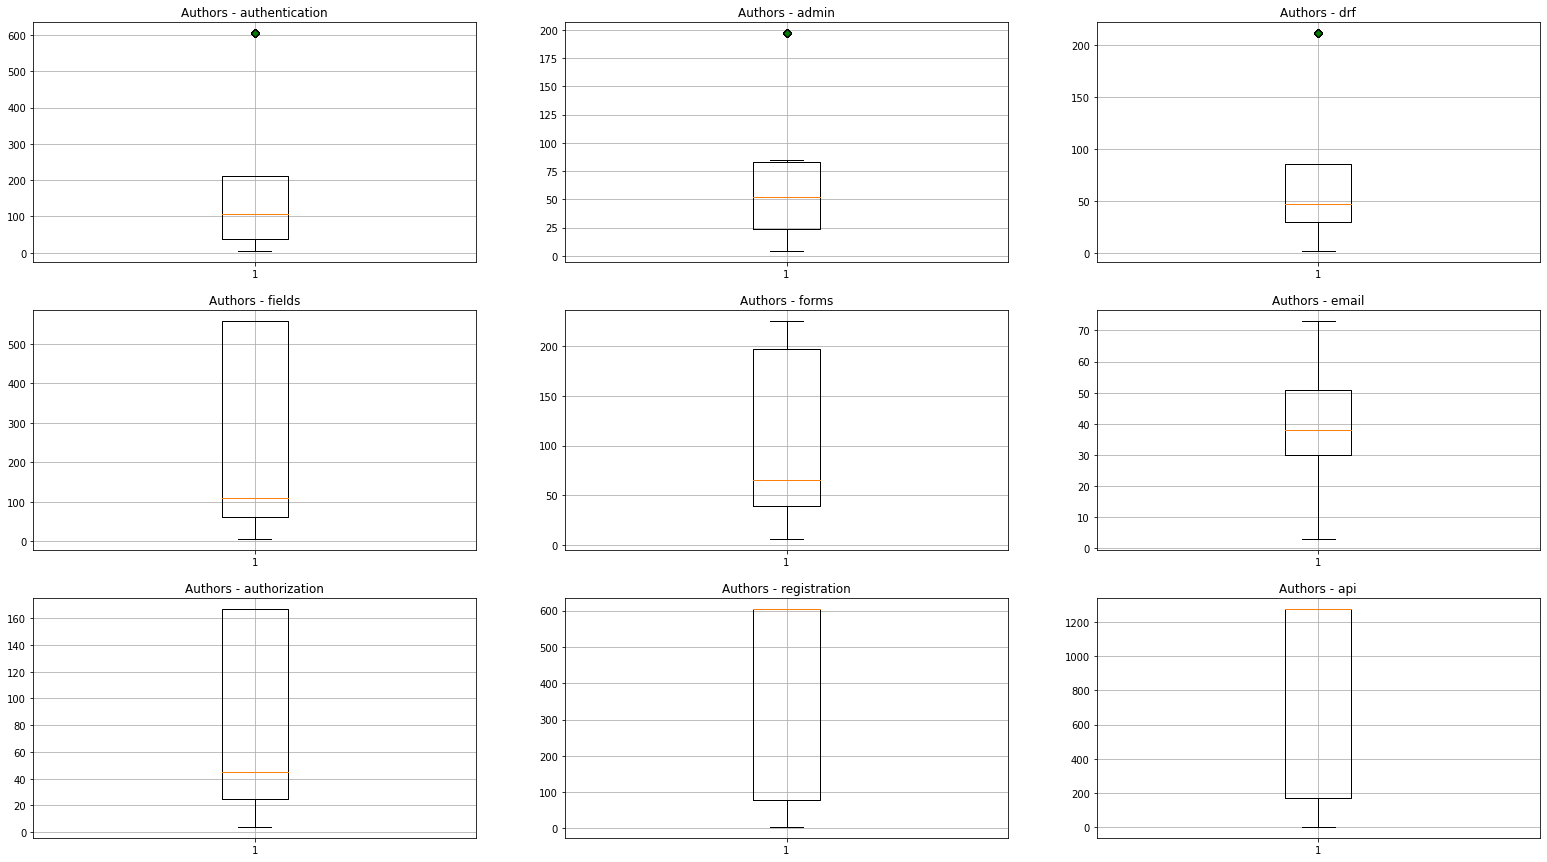

In [7]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(27, 15))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0

for subject, sub_df in sub_dataframes_authors.items():
    sub_df_author = sub_df[['repo_id', 'repo_authors']]
    sub_df_author.drop_duplicates()

    vm.set_boxplot_by_ax(axs[current_axs_index], sub_df_author['repo_authors'].values, 'Authors - {}'.format(subject))
    current_axs_index = current_axs_index + 1

plt.show()

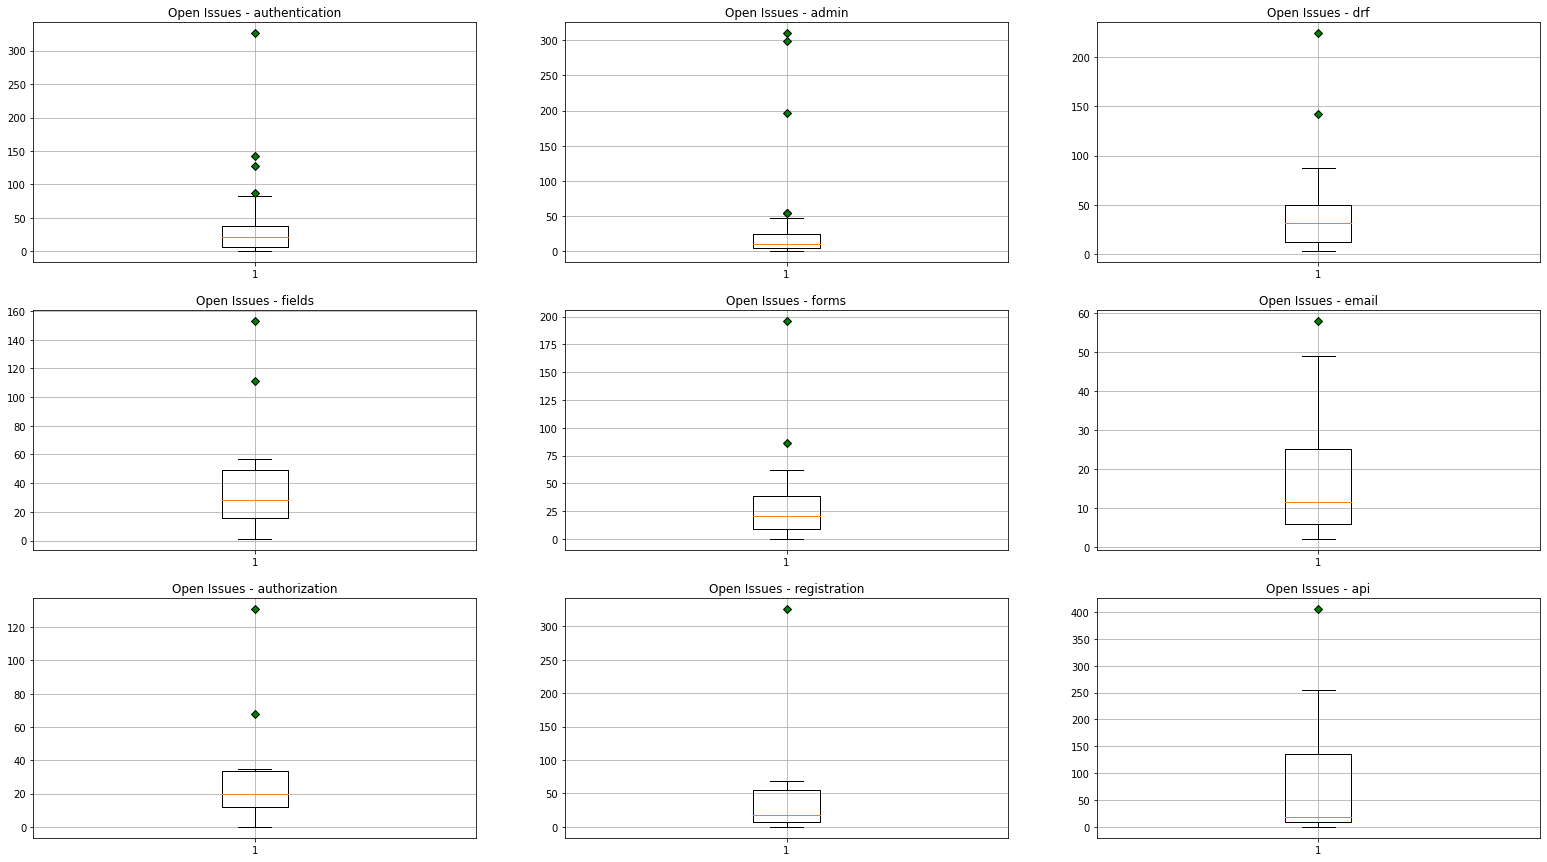

In [8]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(27, 15))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0

for subject, sub_df in sub_dataframes.items():
    vm.set_boxplot_by_ax(axs[current_axs_index], sub_df['repo_open_issues'].values, 'Open Issues - {}'.format(subject))
    current_axs_index = current_axs_index + 1

plt.show()

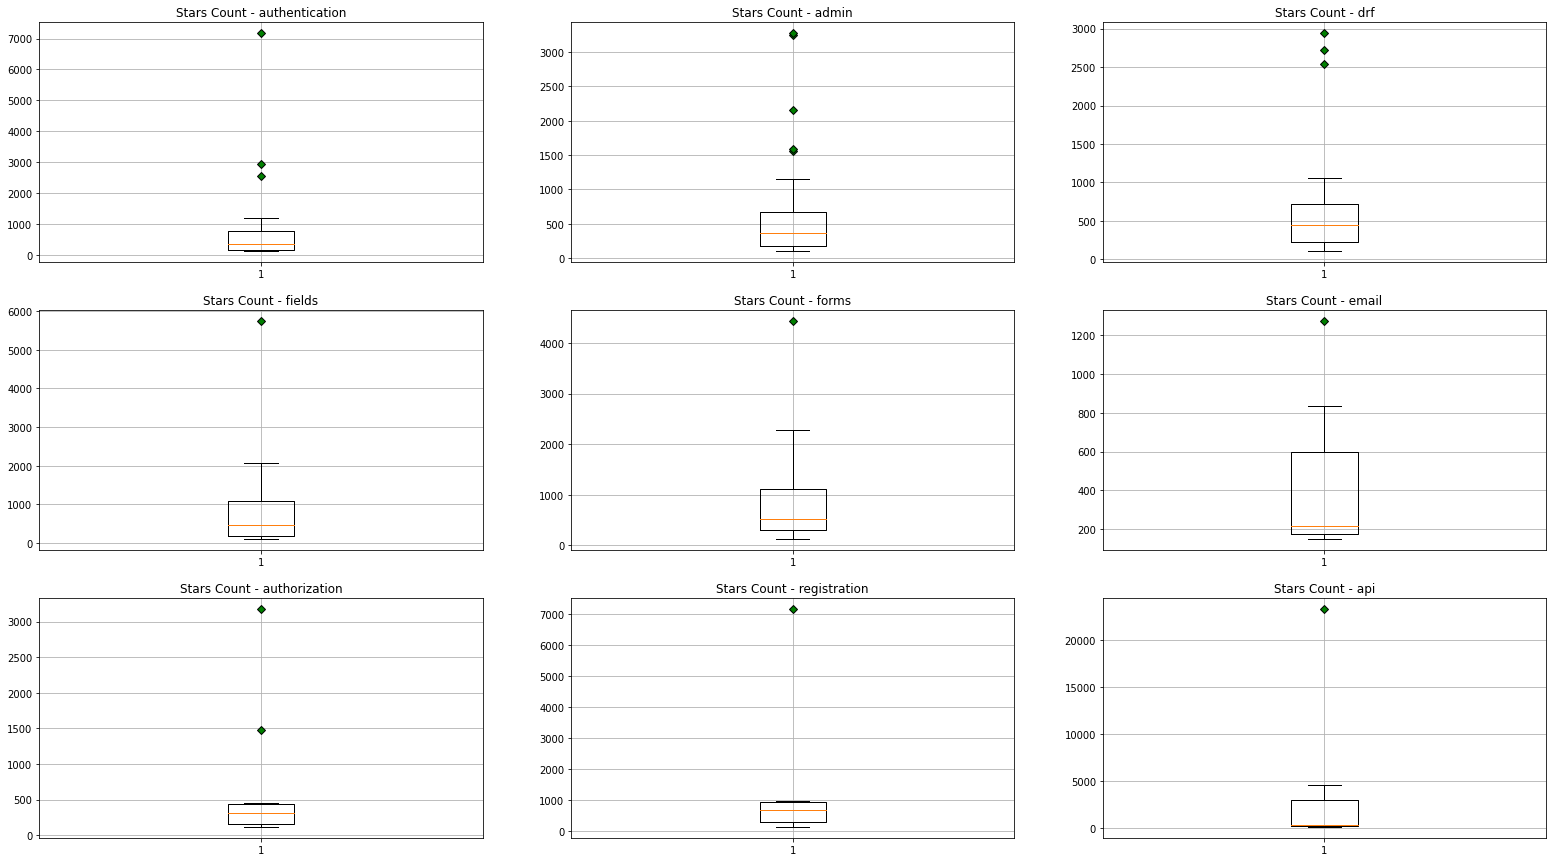

In [9]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(27, 15))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0

for subject, sub_df in sub_dataframes.items():
    vm.set_boxplot_by_ax(axs[current_axs_index], sub_df['repo_stars'].values, 'Stars Count - {}'.format(subject))
    current_axs_index = current_axs_index + 1

plt.show()

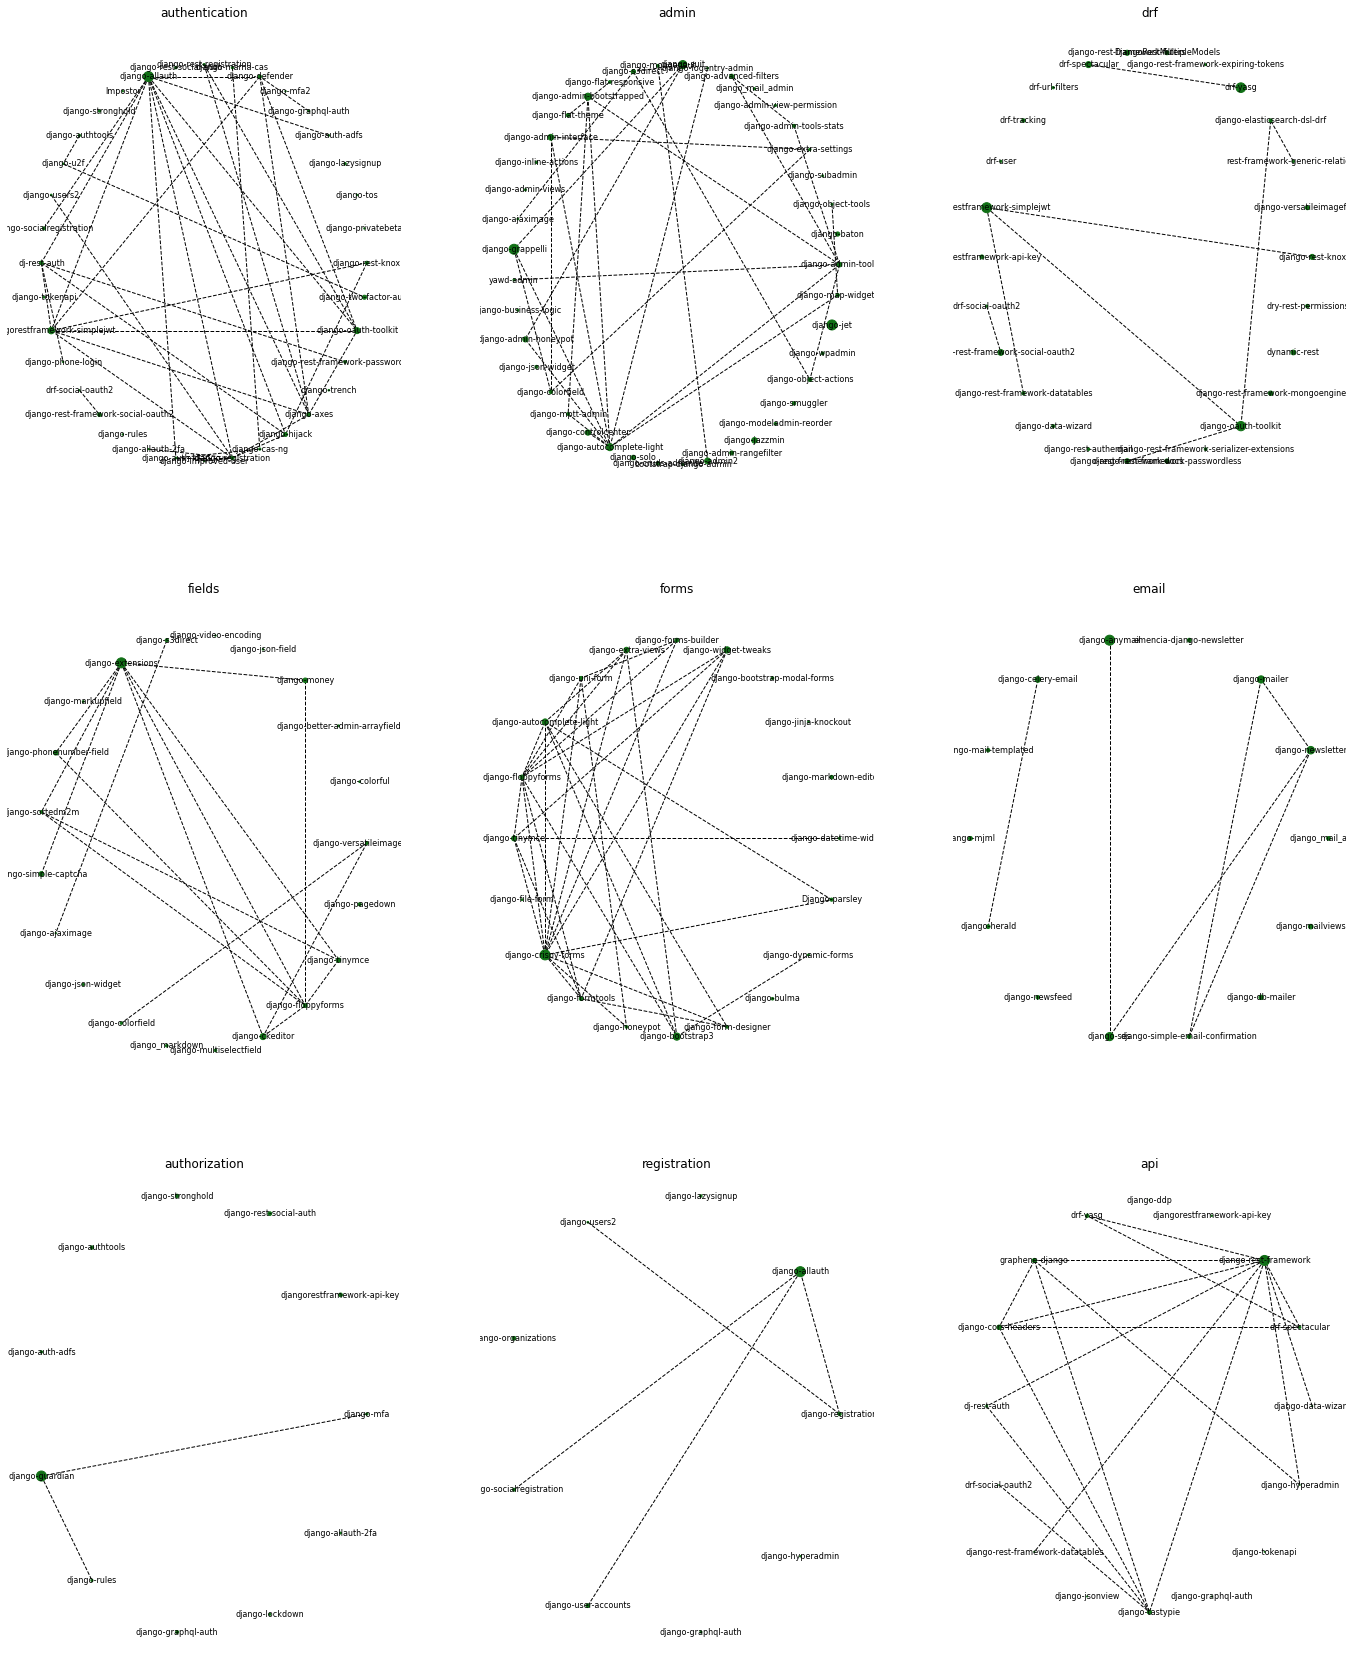

In [10]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(24, 30))
axs = [row1[0], row1[1], row1[2], row2[0], row2[1], row2[2], row3[0], row3[1], row3[2]]
current_axs_index = 0
max_size_node = 100

options = {
    'node_color': '#117016',
    'edge_color': '#000000',
    'font_size': 8,
    'style': 'dashed',
    'with_labels': True,
    'width': 1,
}

for subject, subgraph in sub_graphs.items():
    pos = nx.circular_layout(subgraph)
    ax = axs[current_axs_index]
    ax.set_title(subject)

    stars = [subgraph.nodes.get(n)['stars'] for n in subgraph.nodes]
    authors = [subgraph.nodes.get(n)['authors'] for n in subgraph.nodes]
    max_stars = max(stars)
    max_authors = max(authors)
    sizes = [(stars[i]*authors[i])/((max_stars*max_authors)/max_size_node) for i in range(len(stars))]
    sizes = [star/(max_stars/max_size_node) for star in stars]

    nx.draw(subgraph, ax=ax, node_size=sizes, label=subject, pos=pos, **options)
    current_axs_index = current_axs_index + 1
